In [2]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

key question:
- time series and other features? 

In [3]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"

In [4]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [5]:
df_series_all.head(10)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_06,Bachtel-Forest,Fagus sylvatica,1,0.593406,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.036220,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_06,Bachtel-Forest,Fagus sylvatica,1,0.360955,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_06,Bachtel-Forest,Fagus sylvatica,1,0.351367,2020,1,2020-01


start from simple model 
- understand the covariance, mean a little better
- gaussian process
- autoregressive model 

1. autoregressive


it seems the lag can be 13... 
- use 13 previous twd observations to build autoregressive model?
- use exogenous variables? 


## data preparation

take median value of same site, same species of twd


? what about temperaturre
 (haven't tested if the same..on the same day at the same site)

In [6]:
 df_series_all.head()


,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


In [7]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [8]:
# twd_tree_series_sites

In [9]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [10]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


In [11]:
# how to train and split the data
# write a function to split the data by site and species as well as proprotion of train, val and test
# then write a function to select window size

def create_training_test_set(df, train_size=0.7, val_size=0.15, test_size=0.15):
    sites = df['site_name'].unique()
    train_list = []
    val_list = []
    test_list = []
    
    for site in sites:
        df_site = df[df['site_name'] == site]
        species = df_site['species'].unique()
        
        for sp in species:
            # we don't drop location and species and ts here, when we create windows we will handle them
            df_sp = df_site[df_site['species'] == sp].sort_values(by='ts', ascending = True).reset_index(drop = True)
            n = len(df_sp)
            train_end = int(n * train_size)
            val_end = int(n * (train_size + val_size))
            
            train_list.append(df_sp.iloc[:train_end])
            val_list.append(df_sp.iloc[train_end:val_end])
            test_list.append(df_sp.iloc[val_end:])
    
    train_df = pd.concat(train_list)
    val_df = pd.concat(val_list)
    test_df = pd.concat(test_list)
    
    return train_df, val_df, test_df



In [13]:
train_df, val_df, test_df = create_training_test_set(df_series_features, train_size=0.7, val_size=0.15, test_size=0.15
                                                  )

# column_indices = {name: i for i, name in enumerate(df_series_features.columns)}

# n = len(df_series_features)
# train_df = df_series_features[0:int(n*0.7)]
# val_df = df_series_features[int(n*0.7):int(n*0.9)]
# test_df = df_series_features[int(n*0.9):]

# num_features = df_series_features.shape[1]

In [14]:
len(train_df['twd'].shift(-10).dropna().tolist()) == len(train_df['twd'].shift(10).dropna().tolist())

True

Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [15]:
# Define columns to normalize
cols_to_normalize = ['pr', 'at', 'ws', 'dp', 'sr', 'lr', 
                    'mch_elevation', 'mch_easting', 'mch_northing']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])

# Transform validation and test data using the same scaler
val_df[cols_to_normalize] = scaler.transform(val_df[cols_to_normalize])
test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])

# Store scaler parameters for later use if needed
scaler_params = {
    'mean_': scaler.mean_,
    'scale_': scaler.scale_
}




In [53]:
# create function to split by window size, augoregressive or not
# think about batch later? but it doesn't matter right because batching is just creating another split and make it tensor 
def spliting_window_single_instance(df:pd.DataFrame, 
                    feature_window_size: np.int32,
                    label_window_size: np.int32,
                    shift = 1,
                    autoregressive = False,
                    feature_index = None
                    ):
    label_input = df['twd']
    features_ts_cols = ['twd', 'pr', 'at', 'ws', 'dp', 'sr', 'lr']
    features_ts_cols_wo_twd = ['pr', 'at', 'ws', 'dp', 'sr', 'lr']
    features_static_cols = ['mch_elevation', 'mch_easting', 'mch_northing', 'Carpinus betulus',
       'Corylus avellana', 'Fagus sylvatica', 'Picea abies',
       'Pinus sylvestris', 'Pseudotsuga menziesii']

    if autoregressive:
        feature_input = df
        n_feature = (feature_window_size +1) * len(features_ts_cols) + len(features_static_cols) -1  # +1 because we would like to keep the current selection, -1 to exclude twd that we would like to predict

    else:
        feature_input = df.drop(columns=['twd'])
        features_ts_cols = features_ts_cols_wo_twd
        n_feature = (feature_window_size +1) * len(features_ts_cols) + len(features_static_cols)

    n_sample = feature_input.shape[0]
    
    # Create feature windows using stride tricks
    n_windows = n_sample - feature_window_size - label_window_size - shift + 1

    # we also need to make sure location and other static features are only included for once...

    # Initialize arrays
     
    features = np.zeros((n_windows, n_feature))
    labels = np.zeros((n_windows, label_window_size))
    
    for i in range(n_windows):
        # Feature window
        start_idx = i
        end_idx = i + feature_window_size # we need to think about when shift is not 1 then we can include twd aand end idx 
        features[i] = np.concatenate([feature_input[features_ts_cols].iloc[start_idx:end_idx, ].to_numpy().reshape(-1), 
                                         feature_input[features_ts_cols_wo_twd+features_static_cols].iloc[end_idx, ].to_numpy().reshape(-1)])
        
        # Label window
        label_start = i + feature_window_size + shift - 1
        label_end = label_start + label_window_size
        labels[i] = label_input[label_start:label_end]

    # label_start_index= range(feature_window_size+shift-1, n_sample-label_window_size)
    # feature_start_index = range(0, n_sample - feature_window_size - label_window_size-shift+1)
            # Convert to tensors if requested
    
            
    return features, labels
    



def spliting_window_and_create_features(df: pd.DataFrame, 
                                        feature_window_size: np.int32,
                                        label_window_size: np.int32,
                                        shift = 1,
                                        autoregressive=False,
                                        batch_size=None,
                                        tensor = False,
                                        feature_index = None):
    
    features_list = []
    labels_list = []
     
    for site in sites:
        df_site = df[df['site_name'] == site]
        species = df_site['species'].unique()
        
        for sp in species:
            df_sp = df_site[df_site['species'] == sp]\
                .sort_values(by='ts', ascending = True)\
                .drop(["species", "site_name", "ts"], axis = 1).reset_index(drop = True)
            features, labels = spliting_window_single_instance(df_sp,
                                                                 feature_window_size,
                                                                 label_window_size,
                                                                 shift,
                                                                 autoregressive,
                                                                 feature_index)
             

            features_list.append(features)
            labels_list.append(labels)

    # Concatenate all features and labels
    all_features = np.concatenate(features_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)


    if feature_index is not None:
        all_features = all_features[:, feature_index]                                             
    if tensor:
        all_features = tf.convert_to_tensor(all_features, dtype=tf.float32)
        all_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
        if batch_size:
            dataset = tf.data.Dataset.from_tensor_slices((all_features, all_labels))
            dataset = dataset.batch(batch_size)
            return dataset
        
    return all_features, all_labels





In [56]:
lag_n = 24
train_X, train_y = spliting_window_and_create_features(train_df, feature_window_size = lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
train_X_at, train_y_at = spliting_window_and_create_features(train_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

val_X, val_y = spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
val_X_at, val_y_at = spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

test_X, test_y = spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
test_X_at, test_y_at = spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

## build simple models - baseline
-  linear regression: autoregressive and non-autoregressive

#### Autoregressive

In [39]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [19]:

rgr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5]).fit(train_X, train_y)
rgr.score(train_X, train_y)

0.34325001973393154

In [20]:
rmse_train = root_mean_squared_error(train_y, rgr.predict(train_X))

y_pred_val =rgr.predict(val_X) 
rmse_val = root_mean_squared_error(val_y,  y_pred_val)
r2 = r2_score(val_y, y_pred_val)

/scratch/tmp.47494189.taoj/ipykernel_3734311/1057981882.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range,x_range, 'k--',
/scratch/tmp.47494189.taoj/ipykernel_3734311/1057981882.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--',
/scratch/tmp.47494189.taoj/ipykernel_3734311/1057981882.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--',


Text(4.58346527777778, 0.0665748766399119, 'RMSE: 0.594\n R2: 0.455')

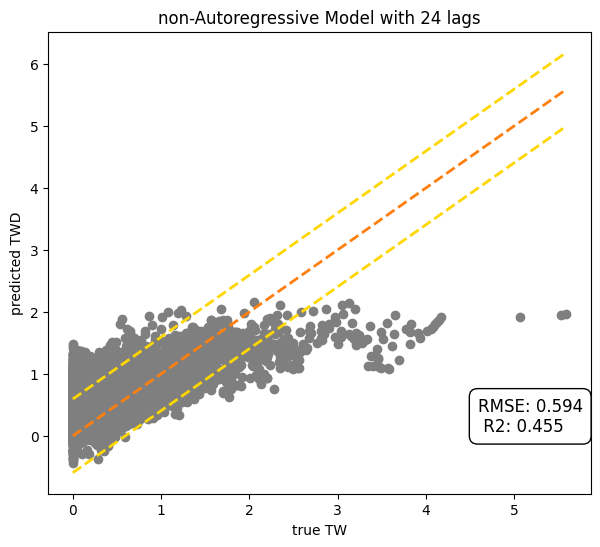

In [21]:
x_scatter = val_y
y_scatter = y_pred_val
rmse_scatter = rmse_val
plt.figure(figsize=(7,6))
plt.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
plt.xlabel("true TW")
plt.ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
plt.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.title(f"non-Autoregressive Model with {lag_n} lags")
plt.text(x_scatter.max()-1, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2:.3f}", 
         fontsize=12, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


it looks like it randomly predict value within the range of 0-2

### autogressive model

In [22]:

rgr_at = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5]).fit(train_X_at, train_y_at)
rgr_at.score(train_X_at, train_y_at)

rmse_train_at = root_mean_squared_error(train_y_at, rgr_at.predict(train_X_at))

y_pred_val_at =rgr_at.predict(val_X_at) 
rmse_val_at = root_mean_squared_error(val_y_at,  y_pred_val_at)

r2_at = r2_score(val_y_at, y_pred_val_at)


In [23]:
y_pred_test_at =rgr_at.predict(test_X_at) 
rmse_test_at = root_mean_squared_error(test_y_at,  y_pred_test_at)
r2_test_at = r2_score(test_y_at, y_pred_test_at)

rmse_test_at
r2_test_at

0.9364245816720189

/scratch/tmp.47494189.taoj/ipykernel_3734311/2001946190.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2001946190.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2001946190.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2001946190.py:47: UserWarning: color is redundantly defined by the 'c

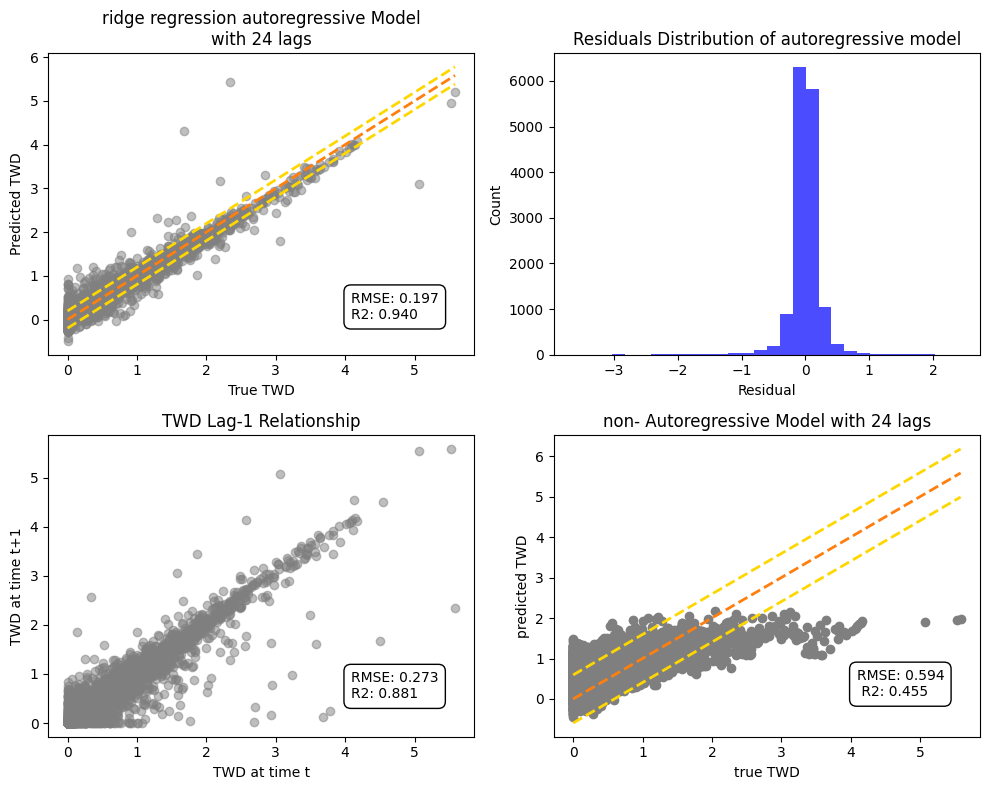

In [25]:
# Create figure with 3 subplots arranged in 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=val_y_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"ridge regression autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5, y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_val_at:.3f}\nR2: {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at.reshape(-1) - rgr_at.predict(train_X_at)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
rmse_lag1 = root_mean_squared_error(val_df["twd"][:-1], val_df['twd'][1:])
r2_score_lag1 = r2_score(val_df["twd"][:-1], val_df['twd'][1:])
ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# add non-auto regressive model results
x_scatter = val_y
y_scatter = y_pred_val
rmse_scatter = rmse_val
ax4.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
ax4.set_xlabel("true TWD")
ax4.set_ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
ax4.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
ax4.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
ax4.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
ax4.set_title(f"non- Autoregressive Model with {lag_n} lags")
ax4.text(x_scatter.max()-1.5, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2:.3f}", 
         fontsize=10, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

let's use ridge regression as a benchmark (baseline), 
- but it is also important to understand which feature are important
- what are the outliers in the prediction
- take a look at residual?
- also wondering if we use TWD from the previous day, how would that change the prdiction? 

(array([8.775e+03, 3.016e+03, 1.751e+03, 9.390e+02, 3.770e+02, 2.990e+02,
        8.900e+01, 6.200e+01, 3.000e+01, 2.000e+00]),
 array([0.        , 0.56353969, 1.12707938, 1.69061906, 2.25415875,
        2.81769844, 3.38123813, 3.94477781, 4.5083175 , 5.07185719,
        5.63539688]),
 <BarContainer object of 10 artists>)

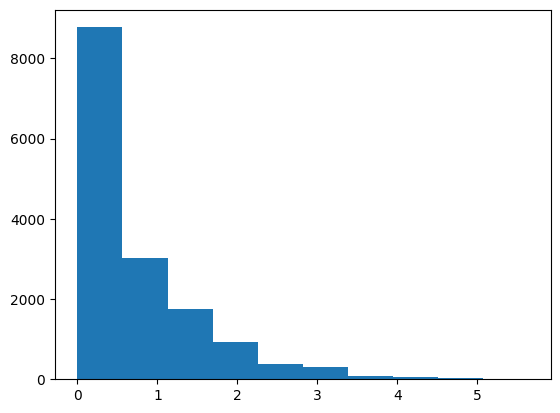

In [26]:
plt.hist(train_df['twd'])

Ridge regression performs slightly better than twd from the day before

let's take a look at feature importance

/scratch/tmp.47494189.taoj/ipykernel_3734311/371732968.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 6)


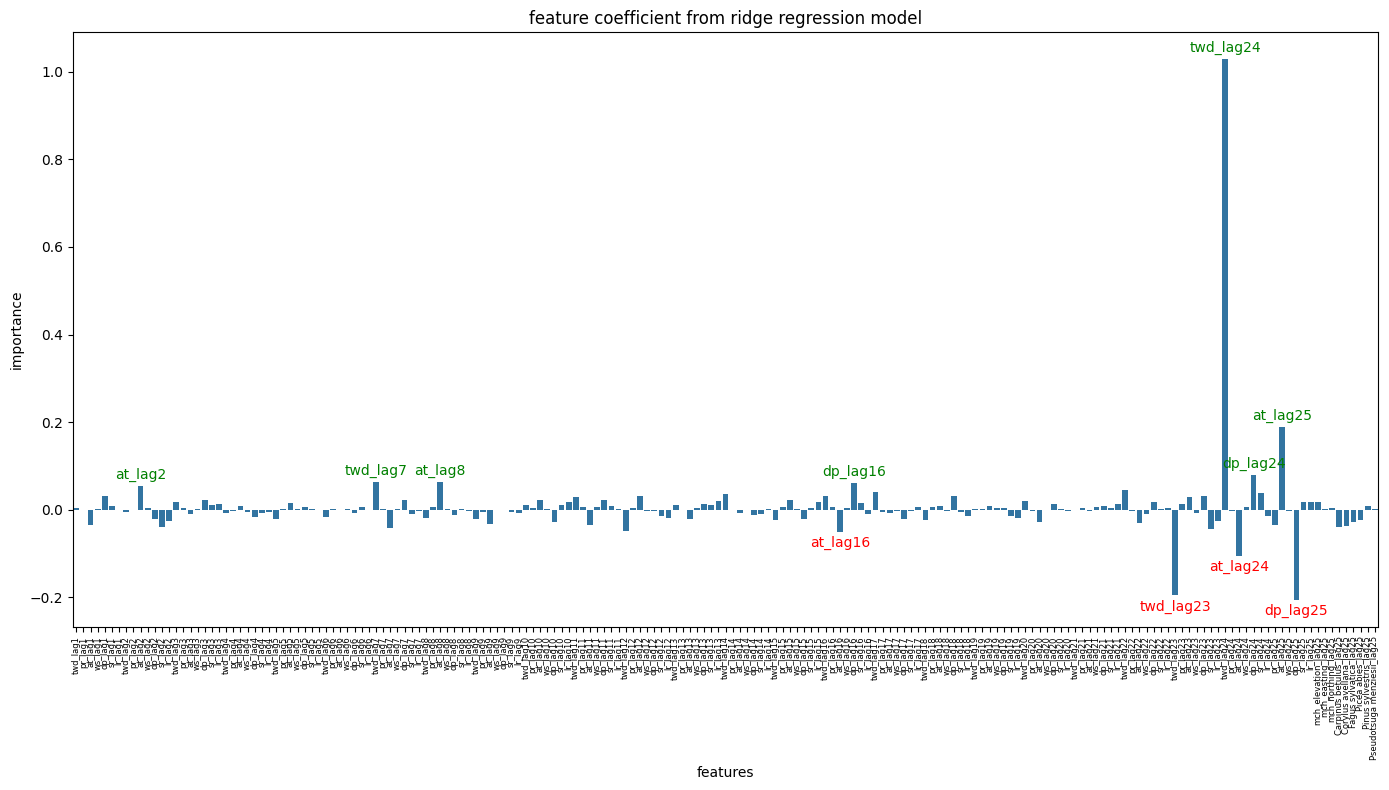

/scratch/tmp.47494189.taoj/ipykernel_3734311/371732968.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 10)


Text(0.5, 1.0, 'feature coefficient (abs(feature_coef) > 0.02)# from ridge regression model')

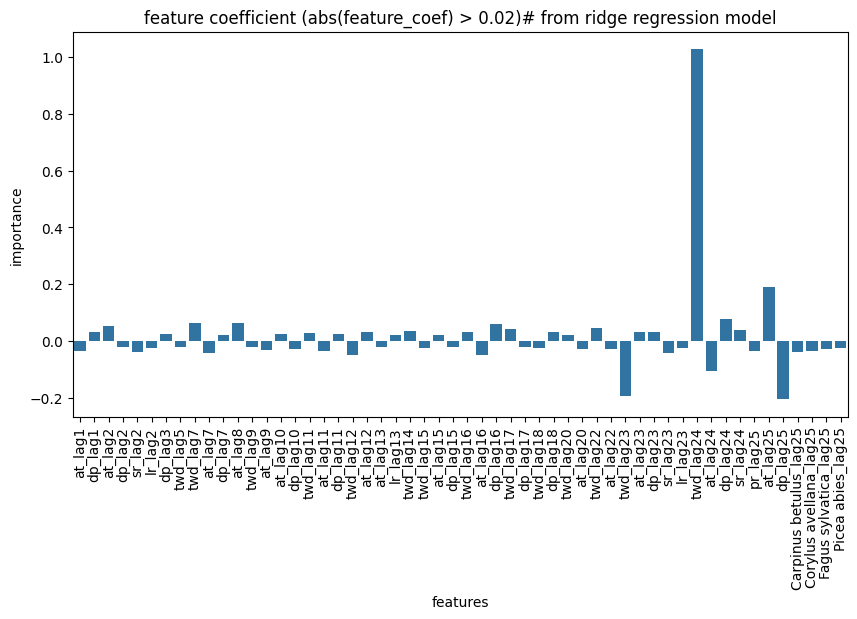

In [27]:
features_ts_cols = ['twd', 'pr', 'at', 'ws', 'dp', 'sr', 'lr']
features_ts_cols_wo_twd = ['pr', 'at', 'ws', 'dp', 'sr', 'lr']
features_static_cols = ['mch_elevation', 'mch_easting', 'mch_northing', 'Carpinus betulus',
       'Corylus avellana', 'Fagus sylvatica', 'Picea abies',
       'Pinus sylvestris', 'Pseudotsuga menziesii']

plt.figure(figsize=(14,8))
lag_labels_at = []

for i in range(1, 26):  # 24 lags
    if i == 25:
        lag_labels_at.extend([f"{col}_lag{i}" for col in features_ts_cols_wo_twd + features_static_cols])
    else:
        lag_labels_at.extend([f"{col}_lag{i}" for col in features_ts_cols])

# lag_labels = [i if "twd" in i else "" for i in lag_labels]
df_reg_imp = pd.DataFrame({
    "features": lag_labels_at,
    "importance": rgr_at.coef_}
)
# df_plot = df_reg_imp.loc[df_reg_imp.importance.abs()>0.05]
df_plot = df_reg_imp
ax = sns.barplot(df_plot, x = "features", y = "importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 6)
ax.set_title("feature coefficient from ridge regression model")
threshold = 0.05
for i, (feature, imp) in enumerate(zip(df_reg_imp['features'], df_reg_imp['importance'])):
    if abs(imp) > threshold:
        color = 'red' if imp < 0 else 'green'
        ax.text(i, imp + (0.01 if imp > 0 else -0.01), 
                feature,
                rotation=0,
                ha='center',
                va='bottom' if imp > 0 else 'top',
                fontsize=10,
                color=color)

plt.tight_layout()
plt.show()

# plt.bar(lag_labels, rgr_at.coef_)
# plt.xticks(lag_labels, rotation=90, fontsize = 7)

plt.figure(figsize=(10,5))
df_plot = df_reg_imp.loc[df_reg_imp.importance.abs()>0.02]
ax = sns.barplot(df_plot, x = "features", y = "importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 10)
ax.set_title("feature coefficient (abs(feature_coef) > 0.02)# from ridge regression model")

In [37]:
reg_impt_feature_index_at = df_reg_imp.loc[df_reg_imp.importance > 0.01, ].index

reg_impt_feature_index_at
# we can use this for non-linear model

Index([  4,   9,  14,  18,  19,  20,  30,  42,  46,  51,  63,  65,  68,  69,
        70,  74,  79,  88,  89,  90,  91, 100, 104, 105, 109, 110, 112, 123,
       133, 137, 146, 147, 151, 155, 156, 158, 161, 165, 166, 169, 172, 173,
       174],
      dtype='int64')

## non-linear models
- simple models: two fcc layers?
- LSTM, CNN, RNN, Transformers?

In [28]:
from keras.models import Sequential, load_model
import tensorflow as tf
import tf_keras

In [29]:
train_X.shape[1]
lag24_num_features = train_X.shape[1]
lag24_num_features/4

39.75

### simple neural nets

In [58]:
# make tensor batch 

batch_size = 64
lag_n = 24
train_tf= spliting_window_and_create_features(train_df, feature_window_size = lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
train_tf_at= spliting_window_and_create_features(train_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=True,  batch_size = batch_size)

val_tf = spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
val_tf_at= spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=True, batch_size = batch_size)

test_tf = spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
test_tf_at= spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor= True, batch_size = batch_size)

2025-11-02 13:22:23.156245: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### non-autoregressive

In [59]:
lag24_num_features = train_X.shape[1]
raw_features = tf_keras.layers.Input(shape = (lag24_num_features, ))

# pre-processing
preprocessor = tf_keras.layers.Dense(40, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)


m1_z1 = tf_keras.layers.Dense(10, activation=tf.nn.relu)(preprocess_features)

m1_pred = tf_keras.layers.Dense(1, activation=None)(m1_z1)


vanilla_net = tf_keras.Model(inputs=raw_features, outputs=m1_pred)#
vanilla_net_nonat =  tf_keras.Model(inputs=raw_features, outputs=m1_pred)#


vanilla_net_nonat.compile(

    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.MeanSquaredError(),  # or simply "mse"
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ]


)

# (Optional) callbacks for better training
early_stop = tf_keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=10, restore_best_weights=True
)



In [60]:
# Fit

history = vanilla_net_nonat.fit(
    train_tf,
    epochs=40,
    validation_data=val_tf,
    callbacks=[early_stop]
)


Epoch 1/40
232/232 [==============================] - 1s 2ms/step - loss: 0.7753 - rmse: 0.8805 - mae: 0.6402 - val_loss: 0.5666 - val_rmse: 0.7527 - val_mae: 0.5200
Epoch 2/40
232/232 [==============================] - 0s 2ms/step - loss: 0.5835 - rmse: 0.7639 - mae: 0.5509 - val_loss: 0.5233 - val_rmse: 0.7234 - val_mae: 0.4729
Epoch 3/40
232/232 [==============================] - 0s 2ms/step - loss: 0.5286 - rmse: 0.7270 - mae: 0.5155 - val_loss: 0.4902 - val_rmse: 0.7001 - val_mae: 0.4541
Epoch 4/40
232/232 [==============================] - 0s 2ms/step - loss: 0.5034 - rmse: 0.7095 - mae: 0.5007 - val_loss: 0.4678 - val_rmse: 0.6840 - val_mae: 0.4447
Epoch 5/40
232/232 [==============================] - 0s 2ms/step - loss: 0.4787 - rmse: 0.6919 - mae: 0.4891 - val_loss: 0.4505 - val_rmse: 0.6712 - val_mae: 0.4410
Epoch 6/40
232/232 [==============================] - 0s 2ms/step - loss: 0.4583 - rmse: 0.6770 - mae: 0.4783 - val_loss: 0.4805 - val_rmse: 0.6932 - val_mae: 0.4608
Epoc

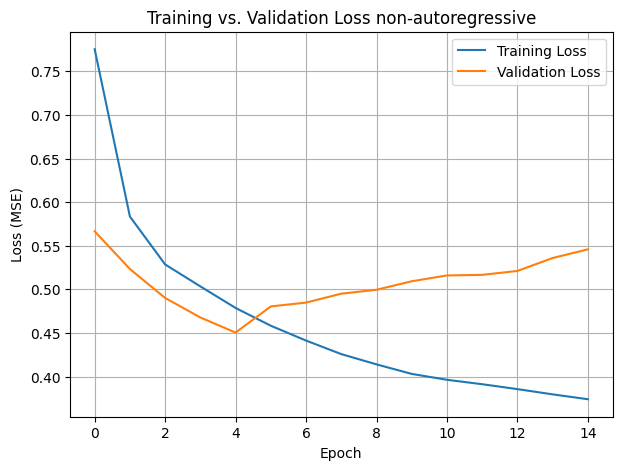

87/87 [==============================] - 0s 1ms/step
rmse: 0.671199, r2: -1.321662 


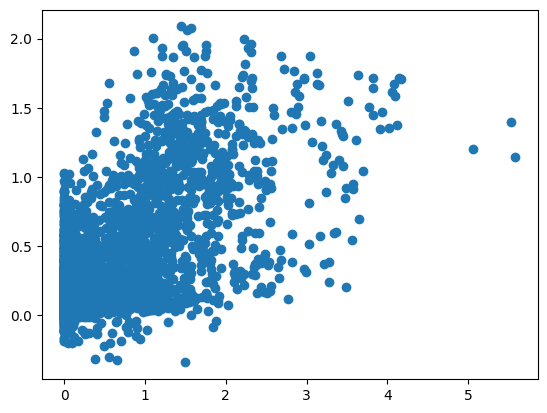

In [62]:


# history = vanilla_net.fit(...)

# Extract loss values
train_loss_nonat= history.history["loss"]
val_loss_nonat = history.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_nonat, label="Training Loss")
plt.plot(val_loss_nonat, label="Validation Loss")
plt.title("Training vs. Validation Loss non-autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_net = vanilla_net_nonat.predict(val_X)# show first few predictions

rmse_net = root_mean_squared_error(y_pred_val_net, val_y)
r2_net = r2_score(y_pred_val_net, val_y)
print(f'rmse: {rmse_net:3f}, r2: {r2_net:3f} ')
plt.scatter(val_y, y_pred_val_net)

### autoregressive

In [63]:
lag24_num_features = train_X_at.shape[1]
raw_features = tf_keras.layers.Input(shape = (lag24_num_features, ))

# pre-processing
preprocessor = tf_keras.layers.Dense(40, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)


m1_z1 = tf_keras.layers.Dense(10, activation=tf.nn.relu)(preprocess_features)

m1_pred = tf_keras.layers.Dense(1, activation=None)(m1_z1)


vanilla_net_at = tf_keras.Model(inputs=raw_features, outputs=m1_pred)#


In [64]:

# Compile: add the missing comma; use RMSE/MAE metrics
vanilla_net_at.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.MeanSquaredError(),  # or simply "mse"
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)




In [ ]:
# Fit

history_at = vanilla_net_at.fit(
    train_tf_at,
    epochs=40,
    validation_data=val_tf_at,
    callbacks=[early_stop]
)



Epoch 1/40


232/232 [==============================] - 1s 2ms/step - loss: 0.3296 - rmse: 0.5741 - mae: 0.4145 - val_loss: 0.1868 - val_rmse: 0.4323 - val_mae: 0.3174
Epoch 2/40
232/232 [==============================] - 0s 2ms/step - loss: 0.1550 - rmse: 0.3937 - mae: 0.2777 - val_loss: 0.1260 - val_rmse: 0.3550 - val_mae: 0.2545
Epoch 3/40
232/232 [==============================] - 0s 2ms/step - loss: 0.1193 - rmse: 0.3453 - mae: 0.2374 - val_loss: 0.1010 - val_rmse: 0.3178 - val_mae: 0.2252
Epoch 4/40
232/232 [==============================] - 0s 2ms/step - loss: 0.1052 - rmse: 0.3243 - mae: 0.2196 - val_loss: 0.0901 - val_rmse: 0.3002 - val_mae: 0.2075
Epoch 5/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0913 - rmse: 0.3021 - mae: 0.2020 - val_loss: 0.0819 - val_rmse: 0.2862 - val_mae: 0.1958
Epoch 6/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0822 - rmse: 0.2867 - mae: 0.1910 - val_loss: 0.0786 - val_rmse: 0.2804 - val_mae: 0.1884
Epoch 7/40
232/

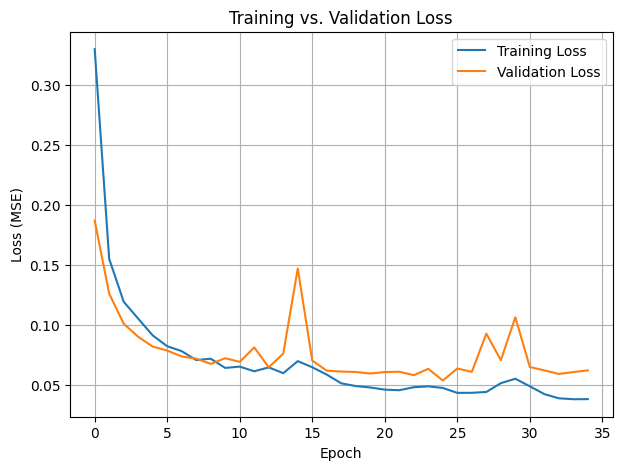

In [66]:


# history = vanilla_net.fit(...)

# Extract loss values
train_loss_at = history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [70]:
y_pred_val_net_at = vanilla_net_at.predict(val_X_at)# show first few predictions

rmse_net_at= root_mean_squared_error(y_pred_val_net_at, val_y_at)
r2_net_at = r2_score(y_pred_val_net_at, val_y_at)

87/87 [==============================] - 0s 797us/step


  1/464 [..............................] - ETA: 5s

118/464 [======>.......................] - ETA: 0s

/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_net_at for i in x_range], 'k--', lw=2, color="gold")


464/464 [==============================] - 0s 704us/step


/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i+rmse_net for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.47494189.taoj/ipykernel_3734311/2253293904.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i-rmse_net for i in x_range], 'k--', lw=2, color="gold")


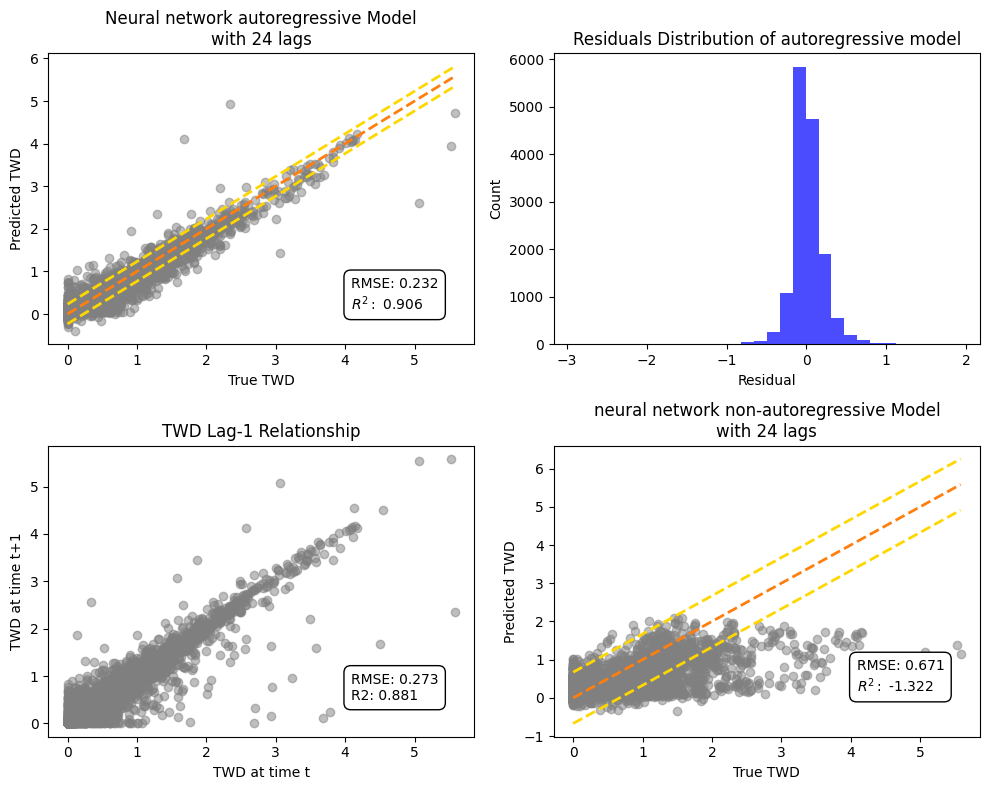

In [72]:
# Create figure with 3 subplots arranged in 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=val_y_at, y=y_pred_val_net_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_net_at.min()+0.5, 
         f"RMSE: {rmse_net_at:.3f}\n$R^2:$ {r2_net_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at.reshape(-1) - vanilla_net_at.predict(train_X_at).reshape(-1)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax4.scatter(x=val_y, y=y_pred_val_net.reshape(-1), color="grey", alpha=0.5)
ax4.set_xlabel("True TWD")
ax4.set_ylabel("Predicted TWD")
x_range = [val_y.min(), val_y.max()]
ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax4.plot(x_range, [i+rmse_net for i in x_range], 'k--', lw=2, color="gold")
ax4.plot(x_range, [i-rmse_net for i in x_range], 'k--', lw=2, color="gold")
ax4.set_title(f"neural network non-autoregressive Model\nwith {lag_n} lags")
ax4.text(val_y.max()-1.5,y_pred_val_net.min()+0.5, 
         f"RMSE: {rmse_net:.3f}\n$R^2:$ {r2_net:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))






# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### select important features - might eliminate noisy features 

In [ ]:
train_imp_ft_at= spliting_window_and_create_features(train_df, feature_window_size = lag_n, 
                                                                    label_window_size=1, shift=1, autoregressive=True, tensor=True,
                                                                    feature_index = reg_impt_feature_index_at,
                                                                    batch_size = 64)
                                                                                                                                        

val_imp_ft_at= spliting_window_and_create_features(val_df, feature_window_size = lag_n, 
                                                                    label_window_size=1, shift=1, autoregressive=True, tensor=True,
                                                                    feature_index = reg_impt_feature_index_at,
                                                                    batch_size = 64)

test_imp_ft_at= spliting_window_and_create_features(test_df, feature_window_size = lag_n, 
                                                                    label_window_size=1, shift=1, autoregressive=True, tensor=True,
                                                                    feature_index = reg_impt_feature_index_at,
                                                                    batch_size = 64)



In [77]:
lag24_num_features = len(reg_impt_feature_index_at)
raw_features = tf_keras.layers.Input(shape = (lag24_num_features, ))

# pre-processing omitted because feature dimension is only 43

m1_z1 = tf_keras.layers.Dense(10, activation=tf.nn.relu)(raw_features)

m1_pred = tf_keras.layers.Dense(1, activation=None)(m1_z1)


vanilla_net_at_ft = tf_keras.Model(inputs=raw_features, outputs=m1_pred)


# Compile: add the missing comma; use RMSE/MAE metrics
vanilla_net_at_ft.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.MeanSquaredError(),  # or simply "mse"
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)


some example function can be borrowed from turorial: 
https://www.tensorflow.org/tutorials/structured_data/time_series

In [79]:
# Fit

history_ft_at = vanilla_net_at_ft.fit(
    train_imp_ft_at,
    epochs=40,
    validation_data=val_imp_ft_at,
    callbacks=[early_stop]
)





Epoch 1/40
 40/232 [====>.........................] - ETA: 0s - loss: 0.0482 - rmse: 0.2196 - mae: 0.1292

232/232 [==============================] - 0s 1ms/step - loss: 0.0554 - rmse: 0.2353 - mae: 0.1420 - val_loss: 0.0443 - val_rmse: 0.2105 - val_mae: 0.1358
Epoch 2/40
232/232 [==============================] - 0s 1ms/step - loss: 0.0552 - rmse: 0.2350 - mae: 0.1418 - val_loss: 0.0442 - val_rmse: 0.2103 - val_mae: 0.1355
Epoch 3/40
232/232 [==============================] - 0s 1ms/step - loss: 0.0551 - rmse: 0.2348 - mae: 0.1417 - val_loss: 0.0440 - val_rmse: 0.2097 - val_mae: 0.1351
Epoch 4/40
232/232 [==============================] - 0s 2ms/step - loss: 0.0550 - rmse: 0.2345 - mae: 0.1414 - val_loss: 0.0437 - val_rmse: 0.2091 - val_mae: 0.1348
Epoch 5/40
232/232 [==============================] - 0s 1ms/step - loss: 0.0549 - rmse: 0.2343 - mae: 0.1413 - val_loss: 0.0436 - val_rmse: 0.2088 - val_mae: 0.1345
Epoch 6/40
232/232 [==============================] - 0s 1ms/step - loss: 0.0548 - rmse: 0.2340 - mae: 0.1410 - val_loss: 0.0434 - val_rmse: 0.2084 - val_mae: 0.1342
Epoch 7/40
232/

In [82]:
val_X_at

array([[ 0.08742675, -0.44245254, -1.08395791, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08665722,  0.53013351, -1.21195181, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08382791, -0.52258498, -0.95512938, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.71654596,  1.3026564 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.25424897,  1.37196037, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.9759405 ,  0.87928366, ...,  0.        ,
         0.        ,  0.        ]], shape=(2780, 183))

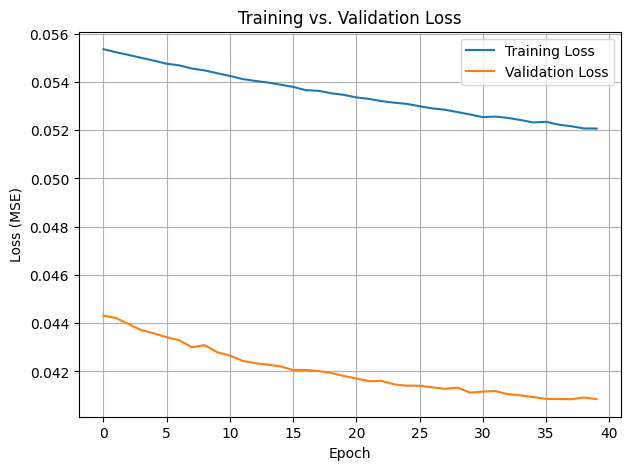

87/87 [==============================] - 0s 665us/step
rmse: 0.202113, r2: 0.933181 
230/464 [=============>................] - ETA: 0s

/scratch/tmp.47494189.taoj/ipykernel_3734311/3973570441.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.47494189.taoj/ipykernel_3734311/3973570441.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_net_ft_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.47494189.taoj/ipykernel_3734311/3973570441.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_net_ft_at  for i in x_range], 'k--', lw=2, color="gold")


464/464 [==============================] - 0s 645us/step


Text(0.5, 1.0, 'Residuals Distribution of autoregressive model')

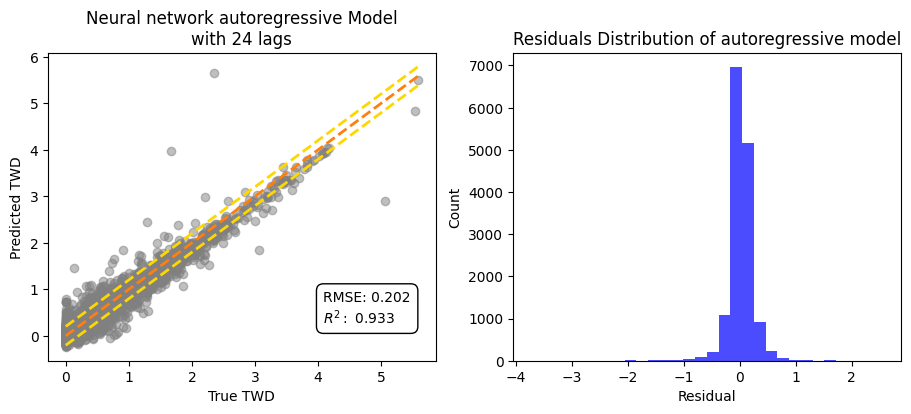

In [92]:


# Extract loss values
train_loss_ft_at = history_ft_at.history["loss"]
val_loss_ft_at = history_ft_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_ft_at, label="Training Loss")
plt.plot(val_loss_ft_at, label="Validation Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


y_pred_val_net_ft_at = vanilla_net_at_ft.predict(val_X_at[:, reg_impt_feature_index_at])# show first few predictions

rmse_net_ft_at = root_mean_squared_error(y_pred_val_net_ft_at, val_y_at)
r2_net_ft_at = r2_score(y_pred_val_net_ft_at, val_y_at)
print(f'rmse: {rmse_net_ft_at:3f}, r2: {r2_net_ft_at:3f} ')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 4))

ax1.scatter(x=val_y_at, y=y_pred_val_net_ft_at, color="grey", alpha=0.5)
# First subplot - Autoregressive Model Predictions
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_net_ft_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_net_ft_at  for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_net_ft_at.min()+0.5, 
         f"RMSE: {rmse_net_ft_at:.3f}\n$R^2:$ {r2_net_ft_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at.reshape(-1) - vanilla_net_at_ft.predict(train_X_at[:, reg_impt_feature_index_at]).reshape(-1)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")
